In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
       'size'   : 13}
matplotlib.rc('font', **font)

from csr2d.beam_conversion import particle_group_to_bmad, bmad_to_particle_group
from pmd_beamphysics.plot import marginal_plot, density_plot
from csr2d.simple_track import track_a_bend, track_a_drift, track_a_bend_parallel, track_a_drift_parallel


from csr2d.kick2 import csr2d_kick_calc, csr1d_steady_state_kick_calc

import time
import h5py

from pmd_beamphysics.interfaces.elegant import elegant_to_data
from pmd_beamphysics import ParticleGroup

import concurrent.futures as cf

import warnings
warnings.filterwarnings("ignore")

import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

## Beam definition 

In [2]:
gamma = 9804
# gamma = 9.784756043574142e+03  # Glen

rho = 10.34 # Bend radius in m
LB = 0.5     # Bend length in m

# Desired beam optics at the END of the bend ( see Yunhai's 3D CSR paper )
beta_xf  = 5.19   # in m
alpha_xf = 0
eta_xf   = 0      # in m
etap_xf  = 0

beta_yf  = 12.28   # in m
alpha_yf = 0
eta_yf   = 0      # in m
etap_yf  = 0

# With the parameters above we can calculate (using Bmad)
# the required INITIAL beam optics at the BEGINNING of the bend
beta_x  = 5.22600574   # in m
alpha_x = 0.07195534
eta_x   = 0.01208662     # in m
etap_x  = -0.04833706

beta_y = 12.30035831    # in m
alpha_y = 0.04071661
eta_y   = 0             # in m
etap_y  = 0

# Beam emittance
norm_emit_x = 1e-6           # in m
emit_x = norm_emit_x / gamma # in m
norm_emit_y = 1e-6           # in m
emit_y = norm_emit_y / gamma # in m

# Bunch length and energy spread
sigma_z  = 2e-5
sigma_delta = 5e-5   # a small value picked by Glen


# Total charge
Nb = 6.25e9
Q = e_charge * Nb


## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
p0c = gamma * beta * mc2  # in eV

# overtaking distance ( for Tao )
L0 = (24*sigma_z*rho**2)**(1/3)

# Characteristic wake in eV/m from Chris's paper
W0 = Nb* r_e * 510998.950 *(sigma_z/rho)**(2/3) / sigma_z**2

In [3]:
# fix random seed 
np.random.seed(0)

# Number of macro particles
Np = 1000000

# charge of one macro-particle
charges = np.ones(Np)*Q/Np  


# Define an uncorrelated beam first
sigma_x = np.sqrt(emit_x * beta_x)
sigma_xp = np.sqrt(emit_x / beta_x)
sigma_y = np.sqrt(emit_y * beta_y)
sigma_yp = np.sqrt(emit_y / beta_y)

beam = np.zeros((6, Np))

beam[0] = np.random.normal(0, sigma_x , size=(1, Np))
beam[1] = np.random.normal(0, sigma_xp , size=(1, Np))
beam[2] = np.random.normal(0, sigma_y , size=(1, Np))
beam[3] = np.random.normal(0, sigma_yp , size=(1, Np))
beam[4] = np.random.normal(0, sigma_z , size=(1, Np))
beam[5] = np.random.normal(0, sigma_delta , size=(1, Np))

#beam[5] = np.zeros(Np)    # turn off initial energy spread

In [4]:
# Introduce coupling and dispersion 
r16 = eta_x
r26 = etap_x

r21 = (-1) * (alpha_x / beta_x) 

r36 = eta_y
r46 = etap_y

r43 = (-1) * (alpha_y / beta_y) 

# Apply coupling to the beam
# Be careful with the order of these lines...

beam[1] = beam[1] + r21 * beam[0] + r26 * beam[5]
beam[0] = beam[0] + r16 * beam[5]

beam[3] = beam[3] + r43 * beam[2] + r46 * beam[5]
beam[2] = beam[2] + r36 * beam[5]

## code

In [5]:
# Copy of a section from kick2.py

from csr2d.convolution import fftconvolve2
from csr2d.kick2 import green_meshes
from scipy.signal import savgol_filter
from csr2d.central_difference import central_difference_z
from csr2d.deposit import split_particles, deposit_particles, histogram_cic_2d

def csr2d_kick_calc_copy(
    z_b,
    x_b,
    weight,
    *,
    gamma=None,
    rho=None,
    nz=100,
    nx=100,
    xlim=None,
    zlim=None,
    reuse_psi_grids=False,
    psi_s_grid_old=None,
    psi_x_grid_old=None,
    map_f=map,
    species="electron",
    imethod='map_coordinates',
    debug=False):
    
    # Grid setup
    if zlim:
        zmin = zlim[0]
        zmax = zlim[1]
    else:
        zmin = z_b.min()
        zmax = z_b.max()

    if xlim:
        xmin = xlim[0]
        xmax = xlim[1]
    else:
        xmin = x_b.min()
        xmax = x_b.max()

    dz = (zmax - zmin) / (nz - 1)
    dx = (xmax - xmin) / (nx - 1)

    # Charge deposition
    t1 = time.time()
    charge_grid = histogram_cic_2d(z_b, x_b, weight, nz, zmin, zmax, nx, xmin, xmax)

    if debug:
        t2 = time.time()
        print("Depositing particles takes:", t2 - t1, "s")

    # Normalize the grid so its integral is unity
    norm = np.sum(charge_grid) * dz * dx
    lambda_grid = charge_grid / norm

    # Apply savgol filter
    lambda_grid_filtered = np.array([savgol_filter(lambda_grid[:, i], 13, 2) for i in np.arange(nx)]).T

    # Differentiation in z
    lambda_grid_filtered_prime = central_difference_z(lambda_grid_filtered, nz, nx, dz, order=1)

    # Grid axis vectors
    zvec = np.linspace(zmin, zmax, nz)
    xvec = np.linspace(xmin, xmax, nx)

    beta = np.sqrt(1 - 1 / gamma ** 2)

    t3 = time.time()

    if reuse_psi_grids == True:
        psi_s_grid = psi_s_grid_old
        psi_x_grid = psi_x_grid_old

    else:
        # Creating the potential grids        
        psi_s_grid, psi_x_grid, zvec2, xvec2 = green_meshes(nz, nx, dz, dx, rho=rho, beta=beta)  
    
    if debug:
        t4 = time.time()
        print("Computing potential grids take:", t4 - t3, "s")

    # Compute the wake via 2d convolution
    conv_s, conv_x = fftconvolve2(lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)
    
    if debug:
        t5 = time.time()
        print("Convolution takes:", t5 - t4, "s")

    Ws_grid = (beta ** 2 / abs(rho)) * (conv_s) * (dz * dx)
    Wx_grid = (beta ** 2 / abs(rho)) * (conv_x) * (dz * dx)
    
    return zvec,xvec,zvec2,xvec2, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid, Ws_grid, Wx_grid, dz, dx

In [6]:
zvec,xvec,zvec2,xvec2, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid, Ws_grid, Wx_grid, dz, dx = csr2d_kick_calc_copy(beam[4,:], beam[0,:], 
                                           charges, gamma=gamma, rho=rho, 
                                           nz=250, nx=200,
                                           map_f = map, debug=True)

Depositing particles takes: 1.0783798694610596 s
Computing potential grids take: 0.03330802917480469 s
Convolution takes: 0.04663252830505371 s


Text(0.5, 1.0, 'CSR wake along x=1.4992630776637325e-08m')

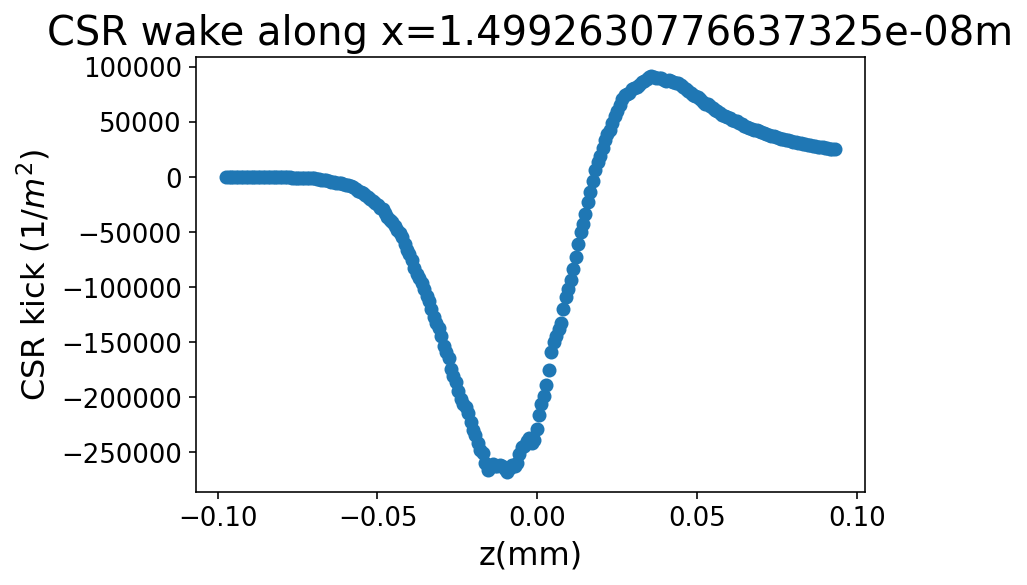

In [7]:
# This should look like steady-state wake
xix = np.argmin(np.abs(xvec - 0))
plt.scatter(zvec*10**3, Ws_grid[:,xix])

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('CSR wake along x='+str(xvec[xix])+'m',  fontsize=20)

In [8]:
# Overtaking phi
print('Phi of the overtaking distance:', L0/10.34)

Phi of the overtaking distance: 0.03593962706139082


In [26]:
psi_s_grid

array([[ -1.17917325,  -1.17324781,  -1.16732236, ...,   1.17320596,
          1.1791313 ,   1.18505663],
       [ -1.18392786,  -1.17797852,  -1.17202919, ...,   1.17793676,
          1.18388599,   1.18983522],
       [ -1.18872096,  -1.18274754,  -1.17677412, ...,   1.18270586,
          1.18867918,   1.19465249],
       ...,
       [-52.95154552, -52.94962131, -52.94769674, ..., -52.16282317,
        -52.1607802 , -52.15873697],
       [-52.87953192, -52.87761523, -52.8756982 , ..., -52.09396773,
        -52.09193308, -52.08989818],
       [-52.80790687, -52.80599765, -52.80408808, ..., -52.02547561,
        -52.02344922, -52.02142258]])

In [29]:
psi_s_grid

array([[ -1.17917325,  -1.17324781,  -1.16732236, ...,   1.17320596,
          1.1791313 ,   1.18505663],
       [ -1.18392786,  -1.17797852,  -1.17202919, ...,   1.17793676,
          1.18388599,   1.18983522],
       [ -1.18872096,  -1.18274754,  -1.17677412, ...,   1.18270586,
          1.18867918,   1.19465249],
       ...,
       [-52.95154552, -52.94962131, -52.94769674, ..., -52.16282317,
        -52.1607802 , -52.15873697],
       [-52.87953192, -52.87761523, -52.8756982 , ..., -52.09396773,
        -52.09193308, -52.08989818],
       [-52.80790687, -52.80599765, -52.80408808, ..., -52.02547561,
        -52.02344922, -52.02142258]])

In [12]:
# phi is the angle into the bend 
# x_observe should be a value in x_vec ( zero might not be one )..... TO BE FIXED

def compute_transient_wake(phi, x_observe, zvec2, xvec2, dz, dx, lambda_grid_filtered_prime, psi_s, psi_x, ploton=True):

    # Boundary condition 
    temp = (x_observe - xvec2)/rho
    zi_vec = rho*(phi-beta*np.sqrt(temp**2 + 4*(1+temp)*np.sin(phi/2)**2))
    zo_vec = -beta*np.abs(x_observe - xvec2)

    
    # Want "True" if (z > zi) OR (z < zo)
    condition_grid = np.array([(zvec2 > zi_vec[i]) | (zvec2 < zo_vec[i]) for i in range(len(xvec2))])
    
    # This section is just for illustration, not required
    if ploton:
        zm2, xm2 = np.meshgrid(zvec2, xvec2, indexing="ij")
        zm2_bounded = zm2
        zm2_bounded[condition_grid.T] = 0
        plt.imshow(zm2_bounded.T, origin='lower')
        plt.colorbar()
        plt.xlabel('zvec2 index', fontsize=16)
        plt.ylabel('xvec2 index', fontsize=16)
        plt.title('z value with boundaries of $\psi_s$\n (x ='+ str(x_observe*1000)+'mm, $\phi=$'+str(phi)+')',  fontsize=20)
        #plt.clf()

    #psi_s_grid_bounded = psi_s.copy()
    #psi_s_grid_bounded[condition_grid.T]=0
    
    psi_s_grid_bounded = np.where(condition_grid.T, 0, psi_s_grid)
    
    conv_s, conv_x = fftconvolve2(lambda_grid_filtered_prime, psi_s_grid_bounded, psi_x)
    Ws_grid = (beta**2 / abs(rho)) * (conv_s) * (dz * dx)
    
    x_observe_index = np.argmin(np.abs(xvec - x_observe))
    print('x_observe_index :', x_observe_index )
    
    #plt.scatter(zvec, Ws_grid[:,x_observe_index])
    
    #return Ws_grid[:,x_observe_index], condition_grid, psi_s_grid_bounded
    return Ws_grid[:,x_observe_index]
    #return Ws_grid

x_observe_index : 102


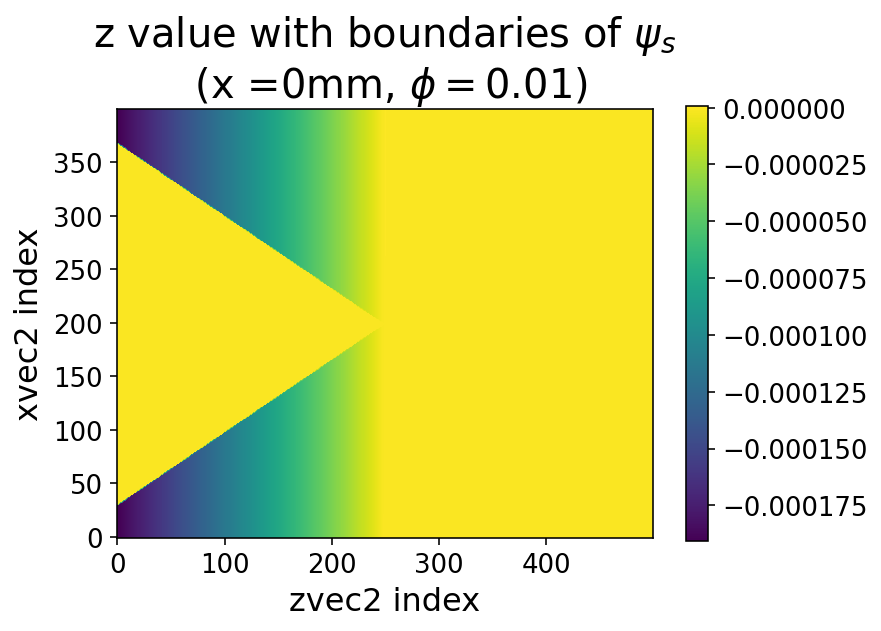

In [19]:
phi = 0.0001
phi = 0.01
x_observe = 0
Ws_on_axis = compute_transient_wake(phi, x_observe, zvec2, xvec2, dz, dx, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)

x_observe_index : 102


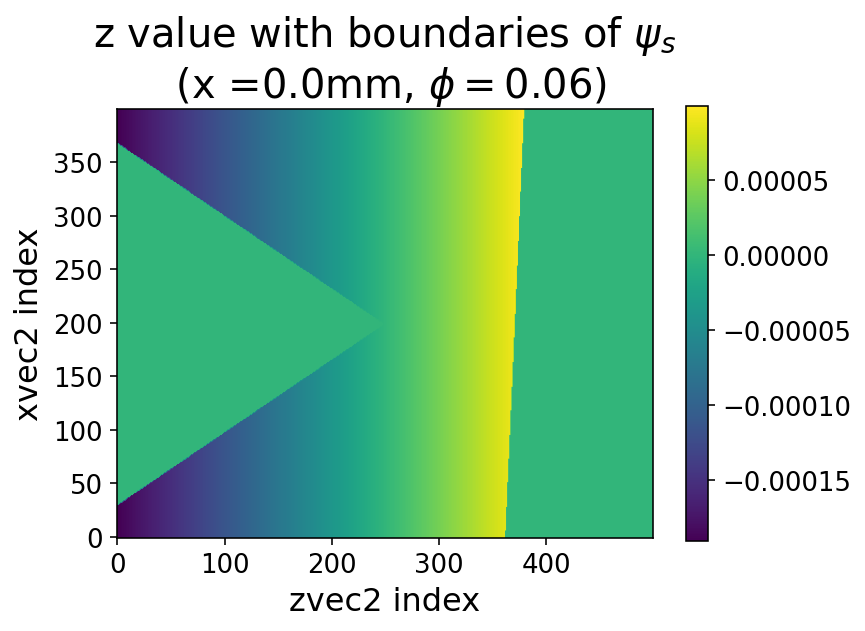

In [14]:
phi = 0.06
x_observe = 0.000
Ws_on_axis = compute_transient_wake(phi, x_observe, zvec2, xvec2, dz, dx, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)

Text(0.5, 1.0, 'CSR wake along x=0\n $\\phi = $0.01')

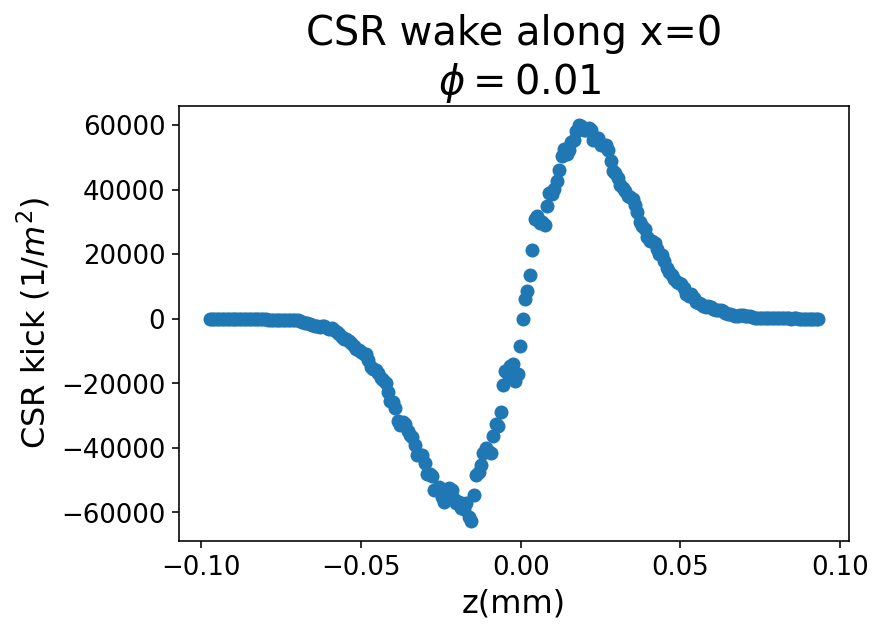

In [20]:
plt.clf()
#plt.scatter(zvec, Ws_on_axis)
plt.scatter(zvec*10**3, Ws_on_axis)

#kick_factor = r_e*Q/e_charge/gamma

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('CSR wake along x='+str(x_observe)+'\n $\phi = $'+str(phi),  fontsize=20)

In [21]:
ff = lambda a : compute_transient_wake(a, x_observe, zvec2, xvec2, dz, dx, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid, ploton=False)
phi_vec = [0.01, 0.02, 0.03, 0.05, 0.06, 0.07]
wake_list = list(map(ff, phi_vec))

x_observe_index : 102
x_observe_index : 102
x_observe_index : 102
x_observe_index : 102
x_observe_index : 102
x_observe_index : 102


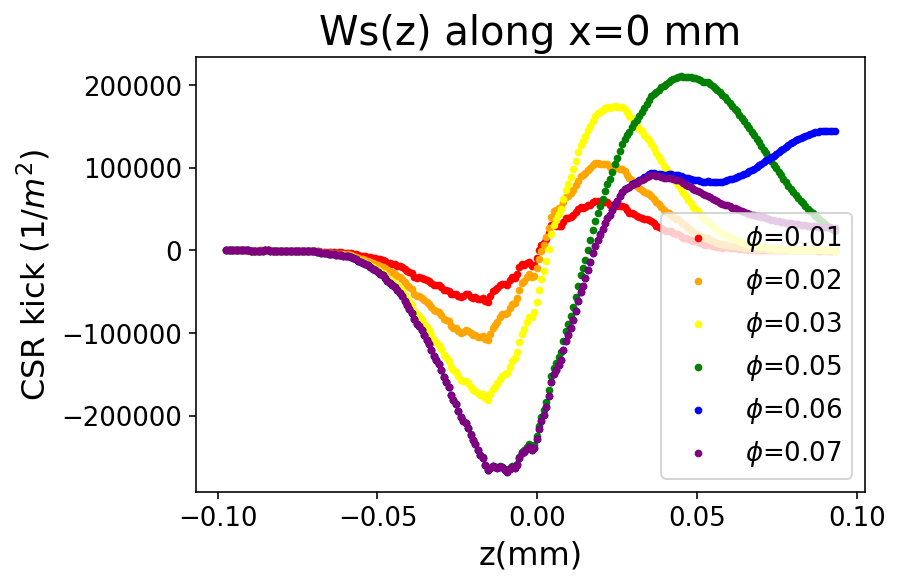

In [22]:
plt.scatter(zvec*10**3,wake_list[0], color='red', label='$\phi$=0.01', s=8 )
plt.scatter(zvec*10**3,wake_list[1], color='orange', label='$\phi$=0.02', s=8    )
plt.scatter(zvec*10**3,wake_list[2], color='yellow', label='$\phi$=0.03', s=8    )
plt.scatter(zvec*10**3,wake_list[3], color='green', label='$\phi$=0.05', s=8    )
plt.scatter(zvec*10**3,wake_list[4], color='blue', label='$\phi$=0.06', s=8    )
plt.scatter(zvec*10**3,wake_list[5], color='purple', label='$\phi$=0.07', s=8    )

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Ws(z) along x='+str(x_observe*1000)+' mm',  fontsize=20)
plt.legend()

## Tao

In [25]:
np.array(phi_vec)*rho

array([0.1034, 0.2068, 0.3102, 0.517 , 0.6204, 0.7238])

In [27]:
#from pytao.misc.csr import read_csr_wake_data_h5, process_csr_wake_data
from pytao.misc.csr import parse_csr_wake

# Below are scratch

In [96]:
print(zvec2[0])
print(zvec2[-1])
print(xvec2[0])
print(xvec2[-1])

-0.0001905963172391465
0.00020421033989908555
-0.0002247420826042827
0.0002497134251158697


In [100]:
zm2[:,0]

array([-1.90596317e-04, -1.76982295e-04, -1.63368272e-04, -1.49754249e-04,
       -1.36140227e-04, -1.22526204e-04, -1.08912181e-04, -9.52981586e-05,
       -8.16841360e-05, -6.80701133e-05, -5.44560906e-05, -4.08420680e-05,
       -2.72280453e-05, -1.36140227e-05,  0.00000000e+00,  1.36140227e-05,
        2.72280453e-05,  4.08420680e-05,  5.44560906e-05,  6.80701133e-05,
        8.16841360e-05,  9.52981586e-05,  1.08912181e-04,  1.22526204e-04,
        1.36140227e-04,  1.49754249e-04,  1.63368272e-04,  1.76982295e-04,
        1.90596317e-04,  2.04210340e-04])

In [109]:
zm2[:,1]

array([-1.90596317e-04, -1.76982295e-04, -1.63368272e-04, -1.49754249e-04,
       -1.36140227e-04, -1.22526204e-04, -1.08912181e-04, -9.52981586e-05,
       -8.16841360e-05, -6.80701133e-05, -5.44560906e-05, -4.08420680e-05,
       -2.72280453e-05, -1.36140227e-05,  0.00000000e+00,  1.36140227e-05,
        2.72280453e-05,  4.08420680e-05,  5.44560906e-05,  6.80701133e-05,
        8.16841360e-05,  9.52981586e-05,  1.08912181e-04,  1.22526204e-04,
        1.36140227e-04,  1.49754249e-04,  1.63368272e-04,  1.76982295e-04,
        1.90596317e-04,  2.04210340e-04])

In [115]:
zvec2

array([-1.90596317e-04, -1.76982295e-04, -1.63368272e-04, -1.49754249e-04,
       -1.36140227e-04, -1.22526204e-04, -1.08912181e-04, -9.52981586e-05,
       -8.16841360e-05, -6.80701133e-05, -5.44560906e-05, -4.08420680e-05,
       -2.72280453e-05, -1.36140227e-05,  0.00000000e+00,  1.36140227e-05,
        2.72280453e-05,  4.08420680e-05,  5.44560906e-05,  6.80701133e-05,
        8.16841360e-05,  9.52981586e-05,  1.08912181e-04,  1.22526204e-04,
        1.36140227e-04,  1.49754249e-04,  1.63368272e-04,  1.76982295e-04,
        1.90596317e-04,  2.04210340e-04])

In [217]:
zvec2 > zi_vec[10]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [218]:
zvec2 < zo_vec[10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [219]:
(zvec2 > zi_vec[10]) | (zvec2 < zo_vec[10])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [343]:
# Want "True" if (z > zi) OR (z < zo)

condition_grid = np.array([(zvec2 > zi_vec[i]) | (zvec2 < zo_vec[i]) for i in range(len(xvec2))])

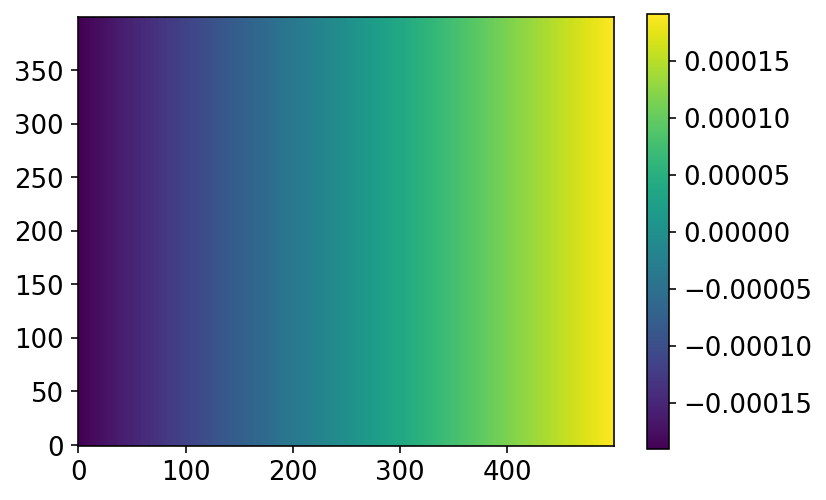

In [544]:
plt.imshow(zm2.T, origin='lower')
plt.colorbar()

In [211]:
zi_vec[10]

0.09264953752397259

In [344]:
zm2_bounded = zm2.copy()
zm2_bounded[condition_grid.T]=0

psi_s_grid_bounded = psi_s_grid.copy()
psi_s_grid_bounded[condition_grid.T]=0

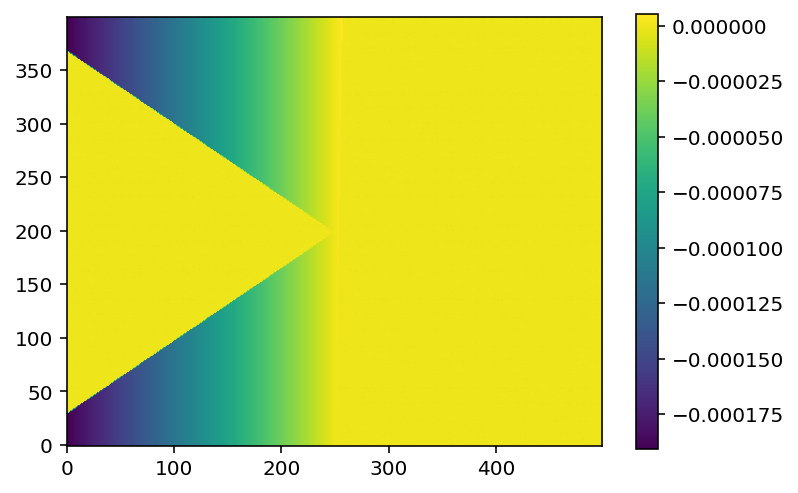

In [345]:
plt.imshow(zm2_bounded.T, origin='lower')
plt.colorbar()

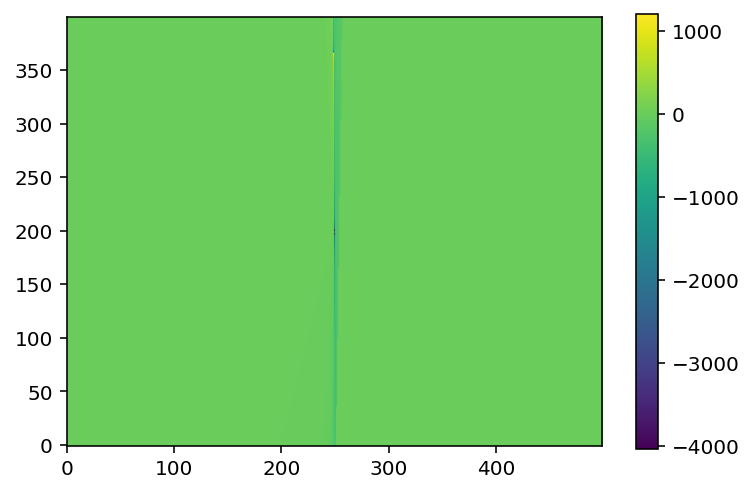

In [346]:
plt.imshow(psi_s_grid_bounded.T, origin='lower')
plt.colorbar()

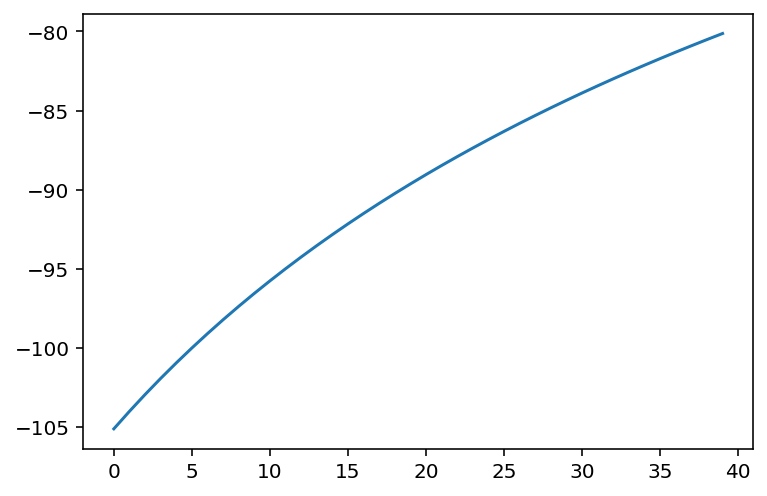

In [329]:
plt.plot(psi_s_grid[280:320,200])

In [347]:
conv_s, conv_x = fftconvolve2(lambda_grid_filtered_prime, psi_s_grid_bounded, psi_x_grid)
Ws_grid = (beta ** 2 / abs(rho)) * (conv_s) * (dz * dx)

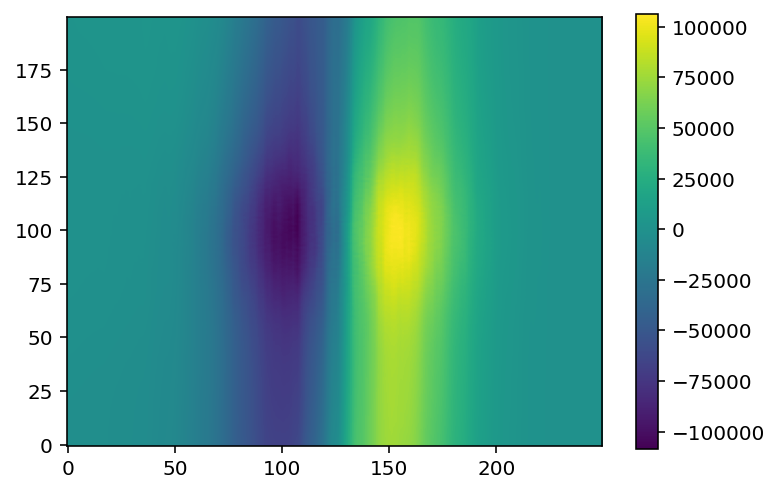

In [348]:
plt.imshow(Ws_grid.T, origin='lower')
plt.colorbar()

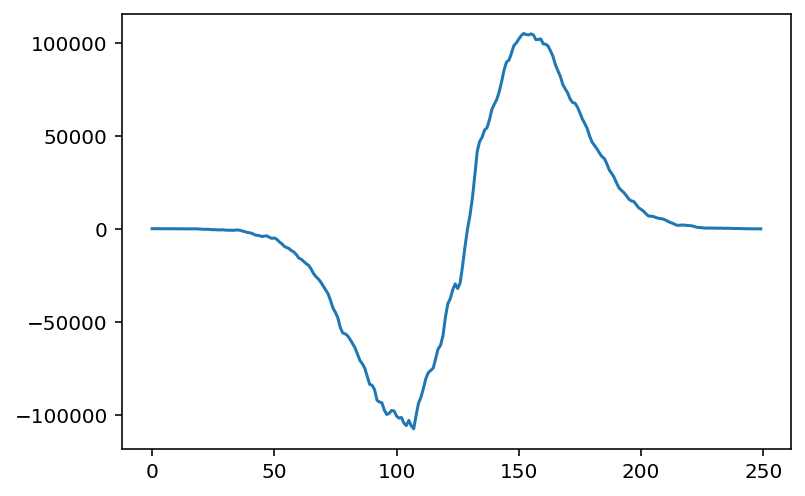

In [349]:
plt.plot(Ws_grid[:,100])

In [262]:
from scipy.signal import fftconvolve

in1 = [[3,4,5],[1,2,3],[7,8,9]]
in1 = [[1,1,1],[1,2,1],[1,1,1]]
in2 = [[1,1,1],[1,1,1],[1,1,1]]
fftconvolve(in1, in2, mode='same', axes=None)

array([[ 5.,  7.,  5.],
       [ 7., 10.,  7.],
       [ 5.,  7.,  5.]])

In [175]:
zvec2

array([-1.90596317e-04, -1.76982295e-04, -1.63368272e-04, -1.49754249e-04,
       -1.36140227e-04, -1.22526204e-04, -1.08912181e-04, -9.52981586e-05,
       -8.16841360e-05, -6.80701133e-05, -5.44560906e-05, -4.08420680e-05,
       -2.72280453e-05, -1.36140227e-05,  0.00000000e+00,  1.36140227e-05,
        2.72280453e-05,  4.08420680e-05,  5.44560906e-05,  6.80701133e-05,
        8.16841360e-05,  9.52981586e-05,  1.08912181e-04,  1.22526204e-04,
        1.36140227e-04,  1.49754249e-04,  1.63368272e-04,  1.76982295e-04,
        1.90596317e-04,  2.04210340e-04])

In [12]:
def make_2d_grids(zmax, zmin, nz, xmax, xmin, nx):    
    
    dz = (zmax - zmin) / (nz - 1)
    dx = (xmax - xmin) / (nx - 1)

    # Grid axis vectors
    zvec = np.linspace(zmin, zmax, nz)
    xvec = np.linspace(xmin, xmax, nx)
    
    # Change to internal coordinates
    #dx = dx/rho
    #dz = dz/(2*abs(rho))
    
    # Double-sized array for convolution with the density
    zvec2 = np.arange(-nz+1,nz+1,1)*dz # center = 0 is at [nz-1]
    xvec2 = np.arange(-nx+1,nx+1,1)*dx # center = 0 is at [nx-1]
    
    #print(zvec2)
    #print(xvec2)
    
    zm2, xm2 = np.meshgrid(zvec2, xvec2, indexing="ij")
    
    return zm2, xm2